In [50]:
import time
import math
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt

import scipy.stats as ss

In [2]:
file = r'donnee.xlsx'
df = pd.read_excel(file)
del df['Unnamed: 0']

In [3]:
temps = df['Temps'].values
s_true = df['signalReel'].values
s_noise = df['signalBruite'].values

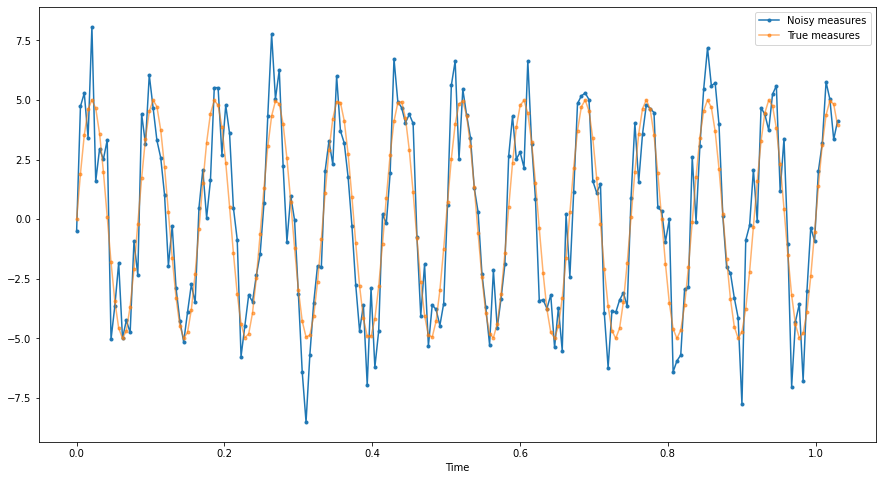

In [4]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(temps[:200], s_noise[:200], '.-', label='Noisy measures')
ax.plot(temps[:200], s_true[:200], '.-', alpha=0.6, label='True measures')
ax.set_xlabel('Time')
ax.legend()
plt.show()

In [65]:
def Kalmann_filter_bis(z) :
    xhat = np.zeros((len(z), 2))
    xhat[0] = np.random.normal(0, 1)

    P = np.zeros((len(z), 2, 2))
    P[0] = np.identity(2)

    t = 0
    while t < len(z) - 1 :
        # estimateur au temps t
        xhat_t = xhat[t]
        # variance au temps t
        b = P[t] + Q
        t += 1
        H_t = np.array([math.sin(2*math.pi*nu0*t*Te + xhat_t[1]), 
                    xhat_t[0]*math.cos(2*math.pi*nu0*t*Te + xhat_t[1])])
        S = np.array(H_t@b@H_t).T + R
        K = b@H_t.T/S

        #On prédit l'état suivant
        epsilon = z[t] - xhat_t[0]*math.sin(2*math.pi*nu0*t*Te + xhat_t[1])
        xhat[t] = xhat_t + K*epsilon

        #Mis à jour
        K = np.array([K]).T
        H_t = np.array([H_t])
        P[t] = b - K@H_t + b
    return(xhat)

In [80]:
A = np.identity(2)
Q = np.array([[2e-5, 0], [0, 2e-1]])
R = 3
nu0, nu_ech = 12, 193.28
Te = 1/nu_ech

In [91]:
def f(x) :
    return A@x

def F(x) :
    return np.eye(2)

def h(x, k) :
    return x[0]*np.sin(2*np.pi*nu0*k*T_ech + x[1])

def H(x, k) :
    return np.array([np.sin(2*np.pi*nu0*k*T_ech + x[1, 0]), 
                    x[0, 0]*np.cos(2*np.pi*nu0*k*T_ech + x[1, 0])]).reshape(1, 2)

def Kalmann_filter(Q, R, f, F, h, H, z) :
    """
    Apply the Extended Kalman filter to the measures z to estimate the state variables
    
    Args:
        Q (int): the variance of the state noise
        
        R (int): the variance of the measure noise
        
        z (array): array of measures
        
    Returns:
        array: estimated and predicted state variables
    """
    
    n = len(z)
    x0 = np.random.normal(size=2).reshape(2, 1)
    P0 = np.eye(2)
    xh, P = [x0], [P0 + Q]
    for k in range(n) :
        # estimation
        S = H(xh[k], k) @ P[k] @ H(xh[k], k).T + R #1x1
        K = P[k] @ H(xh[k], k).T/S #2x1
        err = z[k] - h(xh[k], k) #1x1
        xh[k] = xh[k] + K*err #2x1
        P[k] = P[k] - K @ H(xh[k], k) @ P[k] #2x2
        if k < n - 1 :
            # prediction
            xh.append(f(xh[k]))
            P.append(F(xh[k]) @ P[k] @ F(xh[k]).T)
    xh = np.array(xh).reshape(n, 2)
    return xh

In [93]:
xh = Kalmann_filter(Q, R, f, F, h, H, s_noise[:5000])

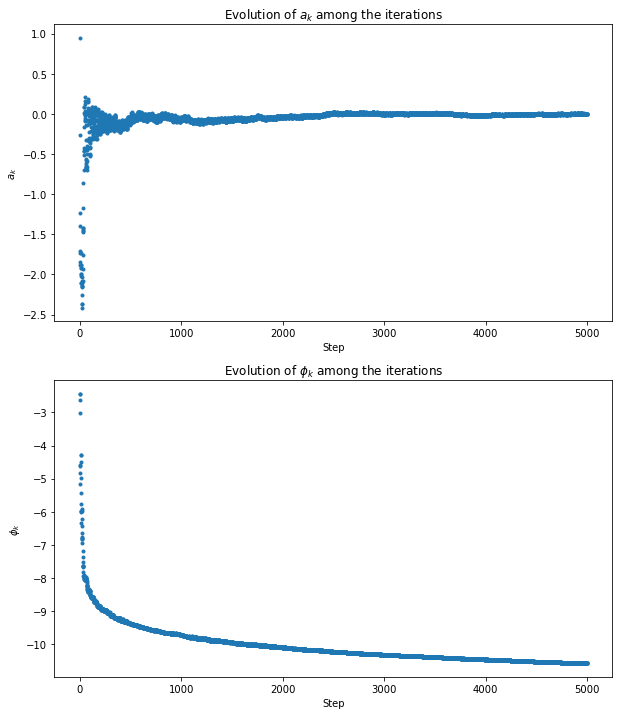

In [94]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.plot(xh[:, 0], '.')
ax1.set_xlabel('Step')
ax1.set_ylabel(r'$a_k$')
ax1.set_title(r'Evolution of $a_k$ among the iterations')

ax2.plot(xh[:, 1], '.')
ax2.set_xlabel('Step')
ax2.set_ylabel(r'$\phi_k$')
ax2.set_title(r'Evolution of $\phi_k$ among the iterations')
plt.show()

In [85]:
def f(x) :
    return A@x

def F(x) :
    return np.eye(2)

def h(x, k) :
    return x[0]*np.sin(2*np.pi*nu0*k*T_ech + x[1])

def H(x, k) :
    return np.array([np.sin(2*np.pi*nu0*k*T_ech + x[1, 0]), 
                    x[0, 0]*np.cos(2*np.pi*nu0*k*T_ech + x[1, 0])]).reshape(1, 2)

def Kalmann_filter3(Q, R, f, F, h, H, z, x0) :
    """
    Apply the Extended Kalman filter to the measures z to estimate the state variables
    
    Args:
        Q (int): the variance of the state noise
        
        R (int): the variance of the measure noise
        
        z (array): array of measures
        
    Returns:
        array: estimated and predicted state variables
    """
    
    n = len(z)
    P0 = np.eye(2)
    xh, P = [x0], [P0 + Q]
    k = 0
    while k < n - 1 :
        #prediction
        xh.append(f(xh[k]))
        P.append(F(xh[k]) @ P[k] @ F(xh[k]).T + Q)
        k += 1
        # estimation
        S = H(xh[k], k) @ P[k] @ H(xh[k], k).T + R #1x1
        K = P[k] @ H(xh[k], k).T/S #2x1
        err = z[k] - h(xh[k], k) #1x1
        xh[k] = xh[k] + K*err #2x1
        P[k] = P[k] - K @ H(xh[k], k) @ P[k] #2x2

    xh = np.array(xh).reshape(n, 2)
    return xh

In [191]:
def f(x) :
    return A@x

def F(x) :
    return np.eye(2)

def h(x, k) :
    return x[0]*np.sin(2*np.pi*nu0*k*T_ech + x[1])

def H(x, k) :
    return np.array([np.sin(2*np.pi*nu0*k*T_ech + x[1]), 
                    x[0]*np.cos(2*np.pi*nu0*k*T_ech + x[1])])

def Kalmann_filter4(Q, R, f, F, h, H, z) :
    """
    Apply the Extended Kalman filter to the measures z to estimate the state variables
    
    Args:
        Q (int): the variance of the state noise
        
        R (int): the variance of the measure noise
        
        z (array): array of measures
        
    Returns:
        array: estimated and predicted state variables
    """
    
    n = len(z)
    P = np.eye(2)
    x = np.random.normal(size=2).reshape(2, 1)
    xh, P_l = [x], [P + Q]
    k = 0
    while k < n - 1 :
        #prediction
        xh_t = x.copy().reshape(2, 1)
        P_t = P + Q
        
        k += 1
        
        # estimation
        H_t = H(xh_t, k).reshape(2, 1) #2x1
        S = H_t.T @ P_t @ H_t + R #1x1
        K = (P_t @ H_t/S).reshape(2, 1) #2x1
        err = z[k] - h(xh_t, k) #1x1
        
        x = xh_t + K*err
        P = P_t - K @ H_t.T * P_t
        
        xh.append(x) #2x1
        P_l.append(P) #2x2

    xh = np.array(xh).reshape(n, 2)
    return xh

In [192]:
xh = Kalmann_filter4(Q, R, f, F, h, H, s_noise)

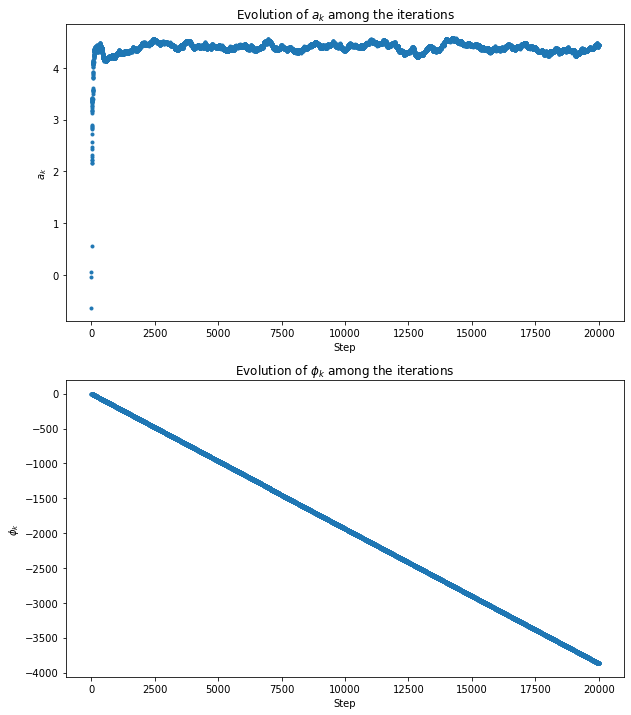

In [193]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.plot(xh[:, 0], '.')
ax1.set_xlabel('Step')
ax1.set_ylabel(r'$a_k$')
ax1.set_title(r'Evolution of $a_k$ among the iterations')

ax2.plot(xh[:, 1], '.')
ax2.set_xlabel('Step')
ax2.set_ylabel(r'$\phi_k$')
ax2.set_title(r'Evolution of $\phi_k$ among the iterations')
plt.show()

In [196]:
idx = np.arange(20000)
s_try = xh[:, 0]*np.sin(2*np.pi*nu0*T_ech*len(xh) + xh[:, 1])

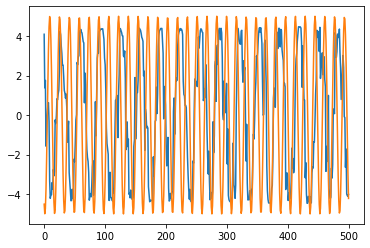

In [197]:
plt.plot(s_try[19500:])
plt.plot(s_true[19500:])